In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql as pysql


In [2]:
try:
    cnn = pysql.connect(host='143.110.154.121', user='root', password='504203DallMySQLServer', database='dwh_us_airlines')
except Exception as ex:
    print("Failed to connect", ex)

# Prediction for future operations
---
### Data preparation

In [3]:
# Select the US airport that you want to analyze and predict its future operations
airport_id = 12478

query_airport_data = "SELECT * FROM dim_local_gateway WHERE id_local_airport = %s;"

airport_data = pd.read_sql(query_airport_data, cnn, params=[airport_id])
airport_code = airport_data['airport_code'].values[0].strip()
airport_name = airport_data['airport_name'].values[0].strip()

airport_data

,id_local_airport,airport_code,world_area_code,airport_name
0,12478,JFK,22,"NEW YORK, NEW YORK, USA"


In [4]:

# Getting the data from the warehouse
query_fl_dt = "SELECT dim_dates.date_full as date, dim_dates.date_year as year, sum(ff.total) as operations FROM us_flights_facts as ff INNER JOIN dim_dates ON ff.id_date = dim_dates.id_date WHERE id_local_airport = %s AND ff.id_type = 1 GROUP BY ff.id_date;"

data_fl_dt = pd.read_sql(query_fl_dt, cnn, params=[airport_id]).sort_values(['date'], ignore_index=True)
data_fl_dt


,date,year,operations
0,1990-01-01 00:00:00,1990,7211.0
1,1990-02-01 00:00:00,1990,6408.0
2,1990-03-01 00:00:00,1990,8098.0
3,1990-04-01 00:00:00,1990,7106.0
4,1990-05-01 00:00:00,1990,7426.0
...,...,...,...
358,2019-11-01 00:00:00,2019,12438.0
359,2019-12-01 00:00:00,2019,13486.0
360,2020-01-01 00:00:00,2020,12873.0
361,2020-02-01 00:00:00,2020,11455.0


### Data Preview

1080


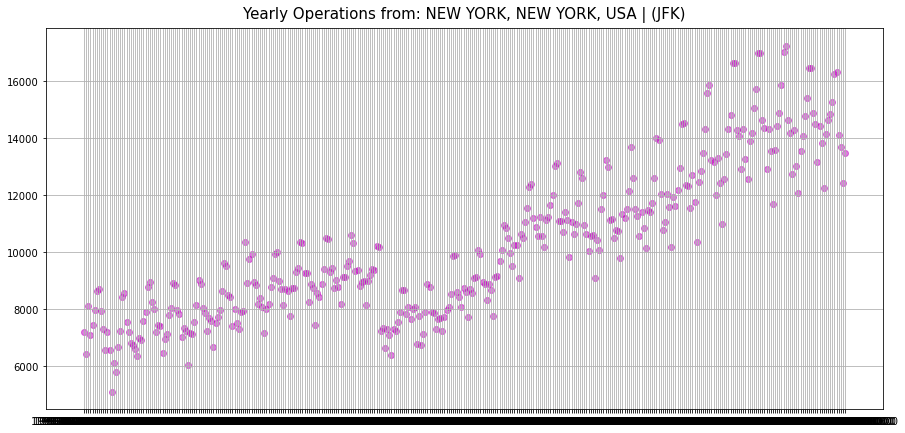

In [5]:
# Remove 2020 as is not completed
clean_df = pd.DataFrame(data_fl_dt[data_fl_dt['year'] != 2020])
print(clean_df.size)

date = clean_df['date']
operations = clean_df['operations']

plt.figure(figsize=(15, 7))
plt.title(f"Yearly Operations from: {airport_name} | ({airport_code})", pad=10, fontdict={
  'fontsize': 15
})
plt.scatter(date, operations, c=['m'], alpha=0.5)
plt.grid()

### Linear regression
$$ \beta(x) = w_1x + b

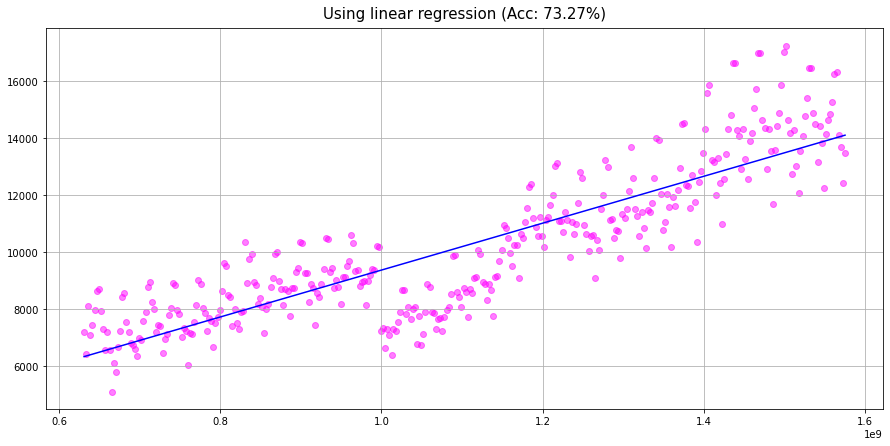

In [6]:
# Linear Regression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Convert DateTime to int timestamps to get cuantitative values
timestamps = pd.to_datetime(date).astype(np.int64) / 10**9

# Get a vector representation for the axes
X = np.array(timestamps).reshape(-1, 1)
Y = np.array(operations).reshape(-1, 1)

# Generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25)

# Create the Linear Regression Model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Test model accuracy
model_acc = model.score(X_test, y_test)

# Visualize model against real data
plt.figure(figsize=(15, 7))
plt.title(f"Using linear regression (Acc: {round((model_acc * 100), 2)}%)", pad=10, fontdict={
    'fontsize': 15
})
plt.scatter(X, Y, color="magenta", alpha=0.5)
plt.grid()
plt.plot(X, model.predict(X), color="blue");


### Polynomial Regression 
$$ \beta(x) = ax^5 + bx^4 + cx^3 + dx^2 + ex + f 

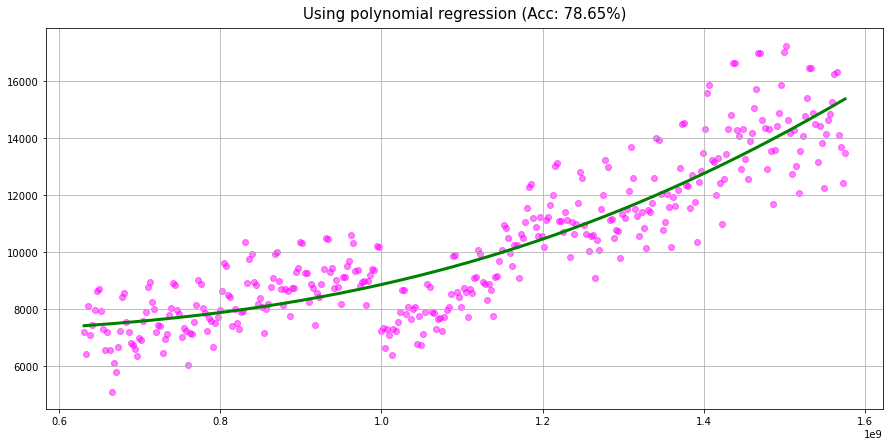

In [7]:
# Using a Polynomial model to fit the curve

# We will need to preprocess the input data before feeding the model
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=5)

X_train_poly = poly_reg.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

X_test_poly = poly_reg.fit_transform(X_test)
poly_acc = poly_model.score(X_test_poly, y_test)

# Visualize model against real data
plt.figure(figsize=(15, 7))
plt.title(f"Using polynomial regression (Acc: {round((poly_acc * 100), 2)}%)", pad=10, fontdict={
    'fontsize': 15
})
plt.scatter(X, Y, color="magenta", alpha=0.5)
plt.grid()
plt.plot(X, poly_model.predict(poly_reg.fit_transform(X)),
         color="green", linewidth=3);


# Top 15 Airlines
---

In [8]:
# Get top 15 used Airlines

query_airlines = "SELECT da.carrier_code as code, da.carrier_name as name, da.is_from_us as from_us, count(fl.total) as total FROM us_flights_facts as fl INNER JOIN dim_airline as da ON da.id_airline = fl.id_airline GROUP BY fl.id_airline"

airline_result = pd.read_sql(query_airlines, cnn).sort_values('total', ascending=False)
top_airlines = pd.DataFrame(airline_result.head(15))
top_airlines

,code,name,from_us,total
121,AA,American Airlines Inc.,1,116418
115,DL,Delta Air Lines Inc.,1,95074
196,UA,United Air Lines Inc.,1,82795
104,CO,Continental Air Lines Inc.,1,51185
31,AC,Air Canada,0,40473
426,US,US Airways Inc.,1,31583
0,NW,Northwest Airlines Inc.,1,27222
465,GL,Miami Air International,1,24577
275,FX,Federal Express Corporation,1,23548
59,MX,Compania Mexicana De Aviaci,0,21518


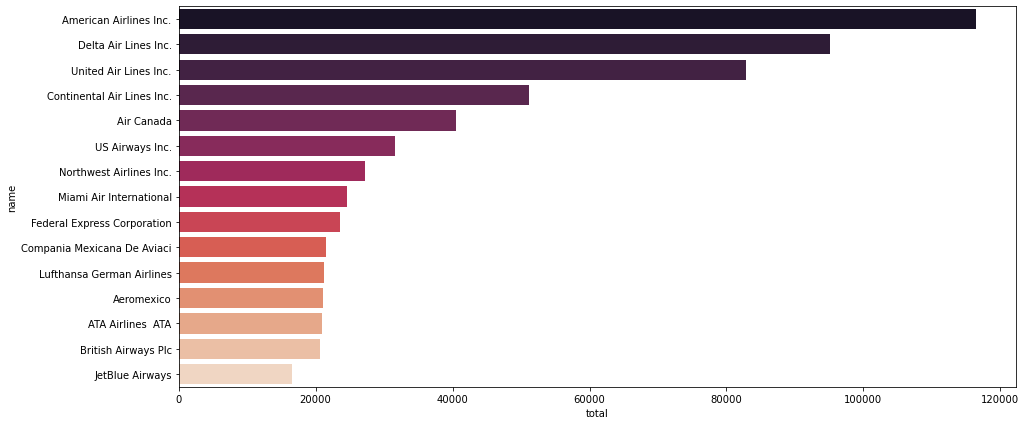

In [9]:
import seaborn as sb

plt.figure(figsize=(15, 7))
ax = sb.barplot(x="total", y="name", data=top_airlines, palette="rocket")


# Top 15 Local Airports
---

In [10]:
query_local_airports = "SELECT dl.airport_code as code, dl.airport_name as name, count(fl.total) as total FROM us_flights_facts as fl INNER JOIN dim_local_gateway as dl ON dl.id_local_airport = fl.id_local_airport GROUP BY fl.id_local_airport;"

local_result = pd.read_sql(query_local_airports, cnn).sort_values('total', ascending=False)
top_local = pd.DataFrame(local_result.head(15))
# Cleanup string values as they contain extra whitespaces
top_local['name'] = top_local['name'].apply(lambda val: val.strip())
top_local

,code,name,total
27,MIA,"MIAMI, FLORIDA, USA",193514
23,JFK,"NEW YORK, NEW YORK, USA",137385
24,LAX,"LOS ANGELES, CALIFORNIA, USA",100861
30,ORD,"CHICAGO, ILLINOIS, USA",74728
16,EWR,"NEWARK, NEW JERSEY, USA",68889
1,IAH,"HOUSTON, TEXAS, USA",58682
7,ATL,"ATLANTA, GEORGIA, USA",52508
37,SFO,"SAN FRANCISCO, CALIFORNIA, USA",39810
11,BOS,"BOSTON, MASSACHUSETTS, USA",38850
69,DFW,"DALLAS/FT.WORTH, TEXAS, USA",38539


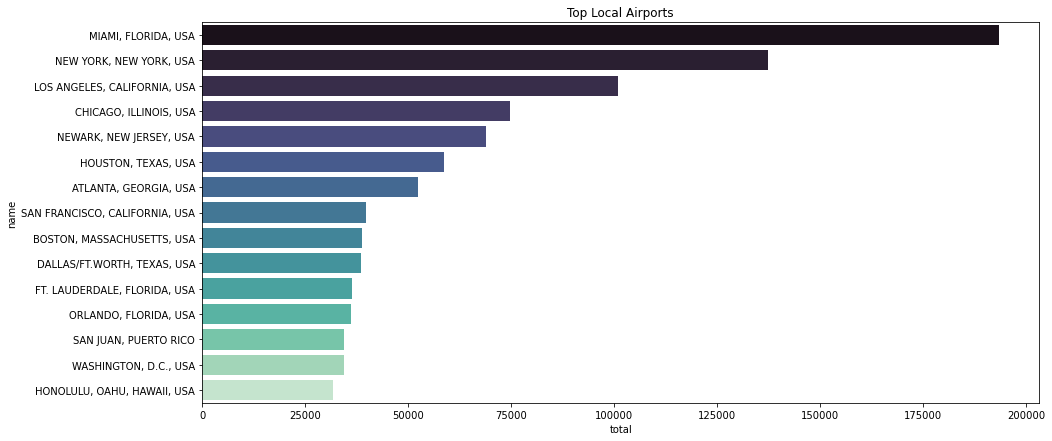

In [11]:
plt.figure(figsize=(15, 7))
plt.title("Top Local Airports")
sb.barplot(x="total", y="name", data=top_local, palette="mako");

# Top 15 Foreign Airports
---

In [12]:
query_foreign_airports = "SELECT df.airport_code AS code, df.airport_name AS name, count(fl.total) AS total FROM us_flights_facts AS fl INNER JOIN dim_foreign_gateway AS df ON df.id_foreign_airport = fl.id_foreign_airport GROUP BY fl.id_foreign_airport;"

foreign_result = pd.read_sql(
    query_foreign_airports, cnn).sort_values('total', ascending=False)
top_foreign = pd.DataFrame(foreign_result.head(15))
# Cleanup extra whitespaces
top_foreign['name'] = top_foreign['name'].apply(lambda val: val.strip())
top_foreign


,code,name,total
130,YYZ,"TORONTO, ONTARIO, CANADA",92509
19,CUN,"CANCUN, MEXICO",57856
55,MEX,"MEXICO CITY, MEXICO",43791
120,YVR,"VANCOUVER, B.C., CANADA",38721
70,NRT,"TOKYO, JAPAN.",37861
119,YUL,"MONTREAL, QUEBEC, CANADA",37535
50,LHR,"LONDON, ENGLAND, UK",31459
28,FRA,"FRANKFURT, GERMANY",31152
64,NAS,"NASSAU, BAHAMAS",27706
126,YYC,"CALGARY, ALTA., CANADA",25367


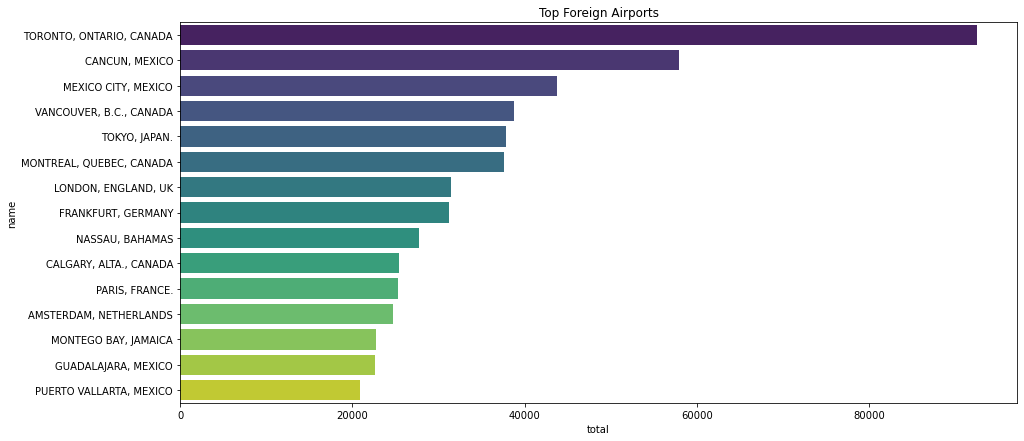

In [13]:
plt.figure(figsize=(15, 7))
plt.title("Top Foreign Airports")
sb.barplot(x="total", y="name", data=top_foreign, palette="viridis");